In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (2.0, 1.0, 1.0, 1.0)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.u_net = Unet(
            encoder_name='resnet34',
            in_channels=16,
            classes=128,
        )

        self.mask_decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.phase_decoder = nn.Sequential(
            nn.Conv2d(in_channels=129, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=5, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.cod_decoder = nn.Sequential(
            nn.Conv2d(in_channels=129, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.cps_decoder = nn.Sequential(
            nn.Conv2d(in_channels=129, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.u_net(x)
        
        cloud_mask_pred = self.mask_decoder(x)

        x = torch.cat([cloud_mask_pred, x], dim=1)

        cloud_phase_pred = self.phase_decoder(x)
        cod_pred = self.cod_decoder(x)
        cps_pred = self.cps_decoder(x)

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred

In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3_1().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Epoch: 1 | Train Loss: 11.3550 | Val Loss: 9.2346 | Val Mask: 0.7063 | Val Phase: 0.5852 | Val Cod: -0.1026 | Val Cps: -1.5568


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 2 | Train Loss: 7.5117 | Val Loss: 6.8570 | Val Mask: 0.8294 | Val Phase: 0.6485 | Val Cod: 0.2162 | Val Cps: -0.8162


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 3 | Train Loss: 5.5583 | Val Loss: 6.6599 | Val Mask: 0.8208 | Val Phase: 0.6105 | Val Cod: 0.3559 | Val Cps: -0.8114


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 4 | Train Loss: 4.4338 | Val Loss: 3.7939 | Val Mask: 0.9132 | Val Phase: 0.7098 | Val Cod: 0.5215 | Val Cps: 0.1920


100%|██████████| 94/94 [00:24<00:00,  3.92it/s]


Epoch: 5 | Train Loss: 3.6462 | Val Loss: 4.0200 | Val Mask: 0.8712 | Val Phase: 0.6989 | Val Cod: 0.5339 | Val Cps: 0.0974


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 6 | Train Loss: 3.0054 | Val Loss: 3.2267 | Val Mask: 0.8955 | Val Phase: 0.7172 | Val Cod: 0.5775 | Val Cps: 0.3840


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 7 | Train Loss: 2.6439 | Val Loss: 2.5279 | Val Mask: 0.9374 | Val Phase: 0.7418 | Val Cod: 0.6370 | Val Cps: 0.5946


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 8 | Train Loss: 2.4225 | Val Loss: 2.4587 | Val Mask: 0.9369 | Val Phase: 0.7406 | Val Cod: 0.6416 | Val Cps: 0.6182


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 9 | Train Loss: 2.3135 | Val Loss: 2.3612 | Val Mask: 0.9361 | Val Phase: 0.7469 | Val Cod: 0.6340 | Val Cps: 0.6528


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 10 | Train Loss: 2.2225 | Val Loss: 2.5058 | Val Mask: 0.9335 | Val Phase: 0.7388 | Val Cod: 0.6090 | Val Cps: 0.6082


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 11 | Train Loss: 2.1620 | Val Loss: 2.8683 | Val Mask: 0.9073 | Val Phase: 0.7279 | Val Cod: 0.5903 | Val Cps: 0.5415


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 12 | Train Loss: 2.1103 | Val Loss: 2.2908 | Val Mask: 0.9401 | Val Phase: 0.7512 | Val Cod: 0.6518 | Val Cps: 0.6614


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 13 | Train Loss: 2.0760 | Val Loss: 2.1282 | Val Mask: 0.9486 | Val Phase: 0.7628 | Val Cod: 0.6749 | Val Cps: 0.6917


100%|██████████| 94/94 [00:23<00:00,  4.01it/s]


Epoch: 14 | Train Loss: 2.0261 | Val Loss: 2.0800 | Val Mask: 0.9506 | Val Phase: 0.7658 | Val Cod: 0.6845 | Val Cps: 0.6996


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 15 | Train Loss: 2.0000 | Val Loss: 2.3189 | Val Mask: 0.9409 | Val Phase: 0.7499 | Val Cod: 0.6104 | Val Cps: 0.6632


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 16 | Train Loss: 1.9541 | Val Loss: 2.1577 | Val Mask: 0.9479 | Val Phase: 0.7583 | Val Cod: 0.6789 | Val Cps: 0.6805


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 17 | Train Loss: 1.9390 | Val Loss: 2.2095 | Val Mask: 0.9416 | Val Phase: 0.7599 | Val Cod: 0.6724 | Val Cps: 0.6749


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 18 | Train Loss: 1.9283 | Val Loss: 2.0707 | Val Mask: 0.9521 | Val Phase: 0.7650 | Val Cod: 0.6784 | Val Cps: 0.7012


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 19 | Train Loss: 1.8984 | Val Loss: 2.1678 | Val Mask: 0.9445 | Val Phase: 0.7583 | Val Cod: 0.6780 | Val Cps: 0.6731


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 20 | Train Loss: 1.8795 | Val Loss: 2.4801 | Val Mask: 0.9303 | Val Phase: 0.7380 | Val Cod: 0.6301 | Val Cps: 0.5996


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 21 | Train Loss: 1.8584 | Val Loss: 2.1422 | Val Mask: 0.9422 | Val Phase: 0.7595 | Val Cod: 0.6933 | Val Cps: 0.6777


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 22 | Train Loss: 1.8417 | Val Loss: 2.1651 | Val Mask: 0.9398 | Val Phase: 0.7593 | Val Cod: 0.6812 | Val Cps: 0.6829


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 23 | Train Loss: 1.8168 | Val Loss: 2.0266 | Val Mask: 0.9521 | Val Phase: 0.7840 | Val Cod: 0.7025 | Val Cps: 0.7036


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 24 | Train Loss: 1.7571 | Val Loss: 2.0017 | Val Mask: 0.9426 | Val Phase: 0.8294 | Val Cod: 0.6999 | Val Cps: 0.6913


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 25 | Train Loss: 1.6973 | Val Loss: 1.8774 | Val Mask: 0.9554 | Val Phase: 0.8396 | Val Cod: 0.7049 | Val Cps: 0.7107


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 26 | Train Loss: 1.6718 | Val Loss: 1.8453 | Val Mask: 0.9574 | Val Phase: 0.8432 | Val Cod: 0.6923 | Val Cps: 0.7216


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 27 | Train Loss: 1.6446 | Val Loss: 1.9888 | Val Mask: 0.9481 | Val Phase: 0.8236 | Val Cod: 0.6985 | Val Cps: 0.6897


100%|██████████| 94/94 [00:23<00:00,  4.00it/s]


Epoch: 28 | Train Loss: 1.6406 | Val Loss: 1.8573 | Val Mask: 0.9575 | Val Phase: 0.8388 | Val Cod: 0.6881 | Val Cps: 0.7279


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 29 | Train Loss: 1.6221 | Val Loss: 1.8247 | Val Mask: 0.9556 | Val Phase: 0.8454 | Val Cod: 0.7109 | Val Cps: 0.7271


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 30 | Train Loss: 1.6207 | Val Loss: 1.7813 | Val Mask: 0.9592 | Val Phase: 0.8464 | Val Cod: 0.7135 | Val Cps: 0.7303


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 31 | Train Loss: 1.5881 | Val Loss: 2.1983 | Val Mask: 0.9382 | Val Phase: 0.8126 | Val Cod: 0.6505 | Val Cps: 0.6387


100%|██████████| 94/94 [00:24<00:00,  3.92it/s]


Epoch: 32 | Train Loss: 1.6142 | Val Loss: 1.7515 | Val Mask: 0.9601 | Val Phase: 0.8501 | Val Cod: 0.7174 | Val Cps: 0.7344


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 33 | Train Loss: 1.5625 | Val Loss: 1.8488 | Val Mask: 0.9543 | Val Phase: 0.8394 | Val Cod: 0.7019 | Val Cps: 0.7276


100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Epoch: 34 | Train Loss: 1.5585 | Val Loss: 1.7697 | Val Mask: 0.9591 | Val Phase: 0.8473 | Val Cod: 0.7172 | Val Cps: 0.7305


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 35 | Train Loss: 1.5480 | Val Loss: 1.8071 | Val Mask: 0.9578 | Val Phase: 0.8485 | Val Cod: 0.6846 | Val Cps: 0.7350


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 36 | Train Loss: 1.5397 | Val Loss: 1.7592 | Val Mask: 0.9594 | Val Phase: 0.8510 | Val Cod: 0.7196 | Val Cps: 0.7317


100%|██████████| 94/94 [00:23<00:00,  4.05it/s]


Epoch: 37 | Train Loss: 1.5159 | Val Loss: 1.7508 | Val Mask: 0.9590 | Val Phase: 0.8544 | Val Cod: 0.7157 | Val Cps: 0.7354


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 38 | Train Loss: 1.5053 | Val Loss: 1.7868 | Val Mask: 0.9560 | Val Phase: 0.8470 | Val Cod: 0.7196 | Val Cps: 0.7258


100%|██████████| 94/94 [00:23<00:00,  4.06it/s]


Epoch: 39 | Train Loss: 1.5021 | Val Loss: 1.7391 | Val Mask: 0.9590 | Val Phase: 0.8542 | Val Cod: 0.7214 | Val Cps: 0.7354


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 40 | Train Loss: 1.4910 | Val Loss: 1.7573 | Val Mask: 0.9608 | Val Phase: 0.8510 | Val Cod: 0.7096 | Val Cps: 0.7365


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 41 | Train Loss: 1.4813 | Val Loss: 1.7688 | Val Mask: 0.9580 | Val Phase: 0.8500 | Val Cod: 0.7150 | Val Cps: 0.7369


100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Epoch: 42 | Train Loss: 1.4854 | Val Loss: 1.7437 | Val Mask: 0.9596 | Val Phase: 0.8538 | Val Cod: 0.7163 | Val Cps: 0.7294


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 43 | Train Loss: 1.4770 | Val Loss: 1.7095 | Val Mask: 0.9619 | Val Phase: 0.8565 | Val Cod: 0.7249 | Val Cps: 0.7415


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 44 | Train Loss: 1.4621 | Val Loss: 1.7258 | Val Mask: 0.9611 | Val Phase: 0.8506 | Val Cod: 0.7221 | Val Cps: 0.7384


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 45 | Train Loss: 1.4566 | Val Loss: 1.8246 | Val Mask: 0.9601 | Val Phase: 0.8388 | Val Cod: 0.6991 | Val Cps: 0.7305


100%|██████████| 94/94 [00:23<00:00,  4.03it/s]


Epoch: 46 | Train Loss: 1.4470 | Val Loss: 1.6936 | Val Mask: 0.9625 | Val Phase: 0.8581 | Val Cod: 0.7273 | Val Cps: 0.7453


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 47 | Train Loss: 1.4451 | Val Loss: 1.7487 | Val Mask: 0.9622 | Val Phase: 0.8498 | Val Cod: 0.7159 | Val Cps: 0.7386


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 48 | Train Loss: 1.4373 | Val Loss: 1.6750 | Val Mask: 0.9634 | Val Phase: 0.8602 | Val Cod: 0.7326 | Val Cps: 0.7470


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 49 | Train Loss: 1.4248 | Val Loss: 1.6786 | Val Mask: 0.9628 | Val Phase: 0.8591 | Val Cod: 0.7324 | Val Cps: 0.7444


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 50 | Train Loss: 1.4264 | Val Loss: 1.7529 | Val Mask: 0.9583 | Val Phase: 0.8541 | Val Cod: 0.7244 | Val Cps: 0.7322


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 51 | Train Loss: 1.4122 | Val Loss: 1.7540 | Val Mask: 0.9632 | Val Phase: 0.8433 | Val Cod: 0.7114 | Val Cps: 0.7395


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 52 | Train Loss: 1.4165 | Val Loss: 1.7420 | Val Mask: 0.9580 | Val Phase: 0.8524 | Val Cod: 0.7161 | Val Cps: 0.7414


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 53 | Train Loss: 1.4073 | Val Loss: 1.9751 | Val Mask: 0.9476 | Val Phase: 0.8417 | Val Cod: 0.6903 | Val Cps: 0.6963


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 54 | Train Loss: 1.3991 | Val Loss: 1.7598 | Val Mask: 0.9597 | Val Phase: 0.8542 | Val Cod: 0.7195 | Val Cps: 0.7412


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 55 | Train Loss: 1.4013 | Val Loss: 1.7566 | Val Mask: 0.9625 | Val Phase: 0.8459 | Val Cod: 0.7060 | Val Cps: 0.7377


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 56 | Train Loss: 1.3890 | Val Loss: 1.7567 | Val Mask: 0.9576 | Val Phase: 0.8528 | Val Cod: 0.7163 | Val Cps: 0.7376


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 57 | Train Loss: 1.3817 | Val Loss: 1.9580 | Val Mask: 0.9539 | Val Phase: 0.8354 | Val Cod: 0.6508 | Val Cps: 0.7221


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 58 | Train Loss: 1.3875 | Val Loss: 1.7394 | Val Mask: 0.9617 | Val Phase: 0.8534 | Val Cod: 0.7281 | Val Cps: 0.7337


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 59 | Train Loss: 1.3836 | Val Loss: 1.9275 | Val Mask: 0.9515 | Val Phase: 0.8327 | Val Cod: 0.7117 | Val Cps: 0.7040


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 60 | Train Loss: 1.3693 | Val Loss: 1.7546 | Val Mask: 0.9630 | Val Phase: 0.8418 | Val Cod: 0.7174 | Val Cps: 0.7417


100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Epoch: 61 | Train Loss: 1.3762 | Val Loss: 1.7016 | Val Mask: 0.9601 | Val Phase: 0.8576 | Val Cod: 0.7323 | Val Cps: 0.7392


100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Epoch: 62 | Train Loss: 1.3594 | Val Loss: 1.7476 | Val Mask: 0.9600 | Val Phase: 0.8568 | Val Cod: 0.7220 | Val Cps: 0.7366


100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Epoch: 63 | Train Loss: 1.3677 | Val Loss: 1.6549 | Val Mask: 0.9636 | Val Phase: 0.8608 | Val Cod: 0.7379 | Val Cps: 0.7514


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 64 | Train Loss: 1.3537 | Val Loss: 1.8431 | Val Mask: 0.9542 | Val Phase: 0.8458 | Val Cod: 0.7051 | Val Cps: 0.7283


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 65 | Train Loss: 1.3552 | Val Loss: 1.6596 | Val Mask: 0.9640 | Val Phase: 0.8607 | Val Cod: 0.7240 | Val Cps: 0.7491


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 66 | Train Loss: 1.3477 | Val Loss: 1.6658 | Val Mask: 0.9638 | Val Phase: 0.8594 | Val Cod: 0.7384 | Val Cps: 0.7512


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 67 | Train Loss: 1.3424 | Val Loss: 1.6756 | Val Mask: 0.9637 | Val Phase: 0.8608 | Val Cod: 0.7288 | Val Cps: 0.7524


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 68 | Train Loss: 1.3394 | Val Loss: 1.6706 | Val Mask: 0.9642 | Val Phase: 0.8549 | Val Cod: 0.7354 | Val Cps: 0.7485


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 69 | Train Loss: 1.3514 | Val Loss: 1.9723 | Val Mask: 0.9529 | Val Phase: 0.8235 | Val Cod: 0.7071 | Val Cps: 0.6935


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 70 | Train Loss: 1.3373 | Val Loss: 1.6233 | Val Mask: 0.9655 | Val Phase: 0.8644 | Val Cod: 0.7399 | Val Cps: 0.7553


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 71 | Train Loss: 1.3283 | Val Loss: 1.6369 | Val Mask: 0.9650 | Val Phase: 0.8622 | Val Cod: 0.7370 | Val Cps: 0.7521


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 72 | Train Loss: 1.3199 | Val Loss: 1.6397 | Val Mask: 0.9638 | Val Phase: 0.8643 | Val Cod: 0.7307 | Val Cps: 0.7504


100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Epoch: 73 | Train Loss: 1.3362 | Val Loss: 1.6968 | Val Mask: 0.9613 | Val Phase: 0.8591 | Val Cod: 0.7323 | Val Cps: 0.7364


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 74 | Train Loss: 1.3305 | Val Loss: 1.6302 | Val Mask: 0.9647 | Val Phase: 0.8654 | Val Cod: 0.7391 | Val Cps: 0.7557


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 75 | Train Loss: 1.3178 | Val Loss: 1.6766 | Val Mask: 0.9615 | Val Phase: 0.8632 | Val Cod: 0.7270 | Val Cps: 0.7491


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 76 | Train Loss: 1.3037 | Val Loss: 1.6716 | Val Mask: 0.9621 | Val Phase: 0.8642 | Val Cod: 0.7320 | Val Cps: 0.7446


100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Epoch: 77 | Train Loss: 1.3012 | Val Loss: 1.6869 | Val Mask: 0.9636 | Val Phase: 0.8538 | Val Cod: 0.7321 | Val Cps: 0.7478


100%|██████████| 94/94 [00:23<00:00,  3.99it/s]


Epoch: 78 | Train Loss: 1.3071 | Val Loss: 1.6773 | Val Mask: 0.9651 | Val Phase: 0.8564 | Val Cod: 0.7271 | Val Cps: 0.7559


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 79 | Train Loss: 1.3037 | Val Loss: 1.5968 | Val Mask: 0.9661 | Val Phase: 0.8681 | Val Cod: 0.7432 | Val Cps: 0.7621


100%|██████████| 94/94 [00:23<00:00,  4.01it/s]


Epoch: 80 | Train Loss: 1.2951 | Val Loss: 1.6222 | Val Mask: 0.9654 | Val Phase: 0.8652 | Val Cod: 0.7367 | Val Cps: 0.7608


100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Epoch: 81 | Train Loss: 1.2918 | Val Loss: 1.6040 | Val Mask: 0.9657 | Val Phase: 0.8679 | Val Cod: 0.7412 | Val Cps: 0.7579


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 82 | Train Loss: 1.2930 | Val Loss: 1.6864 | Val Mask: 0.9603 | Val Phase: 0.8612 | Val Cod: 0.7340 | Val Cps: 0.7348


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 83 | Train Loss: 1.2832 | Val Loss: 1.7712 | Val Mask: 0.9605 | Val Phase: 0.8494 | Val Cod: 0.7252 | Val Cps: 0.7308


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 84 | Train Loss: 1.2795 | Val Loss: 1.7020 | Val Mask: 0.9616 | Val Phase: 0.8562 | Val Cod: 0.7186 | Val Cps: 0.7404


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 85 | Train Loss: 1.2839 | Val Loss: 1.8334 | Val Mask: 0.9530 | Val Phase: 0.8531 | Val Cod: 0.7186 | Val Cps: 0.7196


100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Epoch: 86 | Train Loss: 1.2824 | Val Loss: 1.6538 | Val Mask: 0.9639 | Val Phase: 0.8608 | Val Cod: 0.7356 | Val Cps: 0.7492


100%|██████████| 94/94 [00:23<00:00,  4.06it/s]


Epoch: 87 | Train Loss: 1.2895 | Val Loss: 1.7482 | Val Mask: 0.9611 | Val Phase: 0.8566 | Val Cod: 0.7293 | Val Cps: 0.7402


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 88 | Train Loss: 1.2791 | Val Loss: 1.6741 | Val Mask: 0.9659 | Val Phase: 0.8607 | Val Cod: 0.7280 | Val Cps: 0.7553


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 89 | Train Loss: 1.2776 | Val Loss: 1.7388 | Val Mask: 0.9630 | Val Phase: 0.8450 | Val Cod: 0.7306 | Val Cps: 0.7403


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 90 | Train Loss: 1.2711 | Val Loss: 1.6559 | Val Mask: 0.9647 | Val Phase: 0.8559 | Val Cod: 0.7268 | Val Cps: 0.7514


100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Epoch: 91 | Train Loss: 1.2675 | Val Loss: 1.6274 | Val Mask: 0.9650 | Val Phase: 0.8661 | Val Cod: 0.7404 | Val Cps: 0.7571


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 92 | Train Loss: 1.2655 | Val Loss: 1.6030 | Val Mask: 0.9662 | Val Phase: 0.8686 | Val Cod: 0.7435 | Val Cps: 0.7616


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 93 | Train Loss: 1.2667 | Val Loss: 1.6496 | Val Mask: 0.9629 | Val Phase: 0.8662 | Val Cod: 0.7370 | Val Cps: 0.7460


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 94 | Train Loss: 1.2616 | Val Loss: 1.6828 | Val Mask: 0.9655 | Val Phase: 0.8610 | Val Cod: 0.7065 | Val Cps: 0.7609


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 95 | Train Loss: 1.2617 | Val Loss: 1.6164 | Val Mask: 0.9655 | Val Phase: 0.8685 | Val Cod: 0.7409 | Val Cps: 0.7592


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 96 | Train Loss: 1.2547 | Val Loss: 1.5923 | Val Mask: 0.9663 | Val Phase: 0.8675 | Val Cod: 0.7450 | Val Cps: 0.7586


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 97 | Train Loss: 1.2530 | Val Loss: 1.7874 | Val Mask: 0.9658 | Val Phase: 0.8477 | Val Cod: 0.7075 | Val Cps: 0.7446


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 98 | Train Loss: 1.2501 | Val Loss: 1.6206 | Val Mask: 0.9661 | Val Phase: 0.8641 | Val Cod: 0.7411 | Val Cps: 0.7579


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 99 | Train Loss: 1.2458 | Val Loss: 1.5859 | Val Mask: 0.9667 | Val Phase: 0.8683 | Val Cod: 0.7455 | Val Cps: 0.7628


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 100 | Train Loss: 1.2478 | Val Loss: 1.7062 | Val Mask: 0.9619 | Val Phase: 0.8613 | Val Cod: 0.7311 | Val Cps: 0.7420


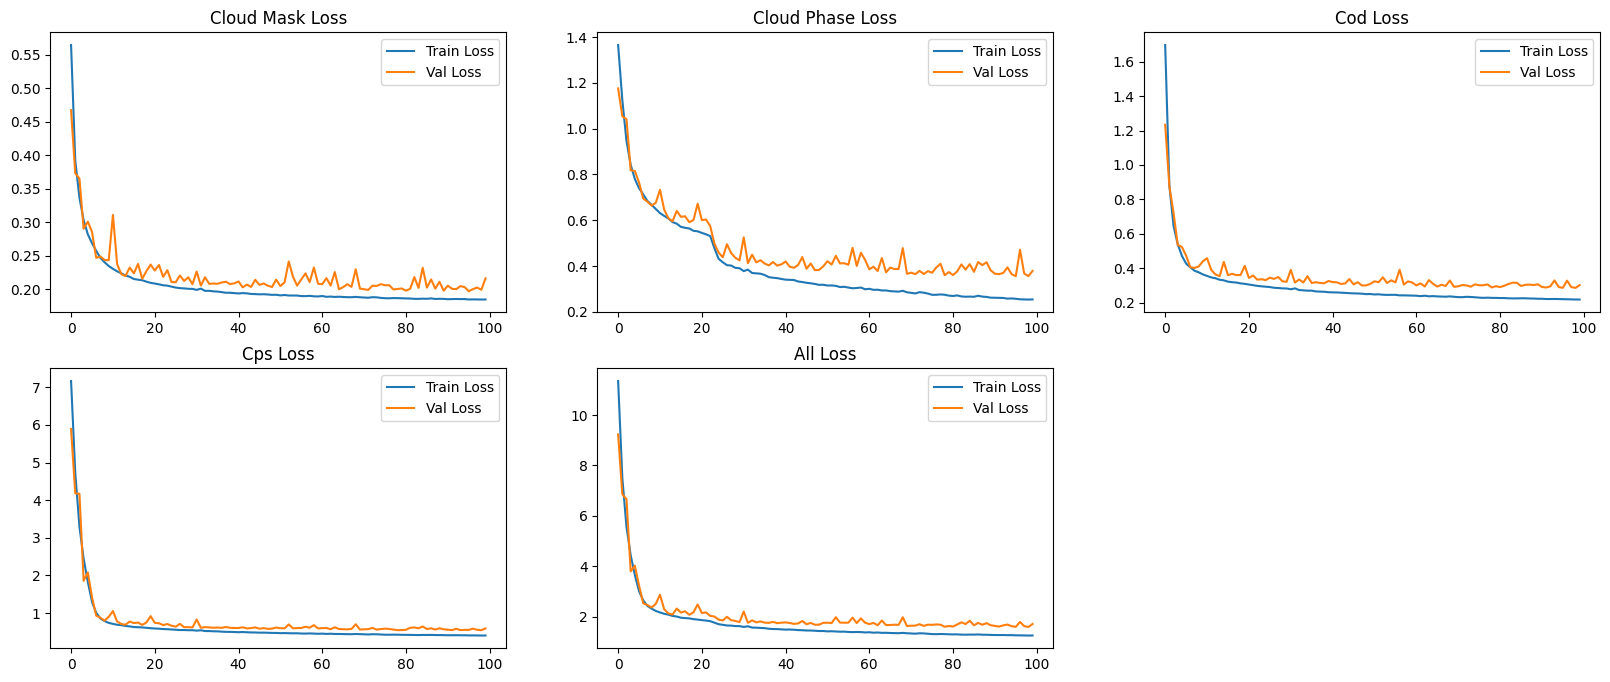

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.2_loss.png")  

plt.show()

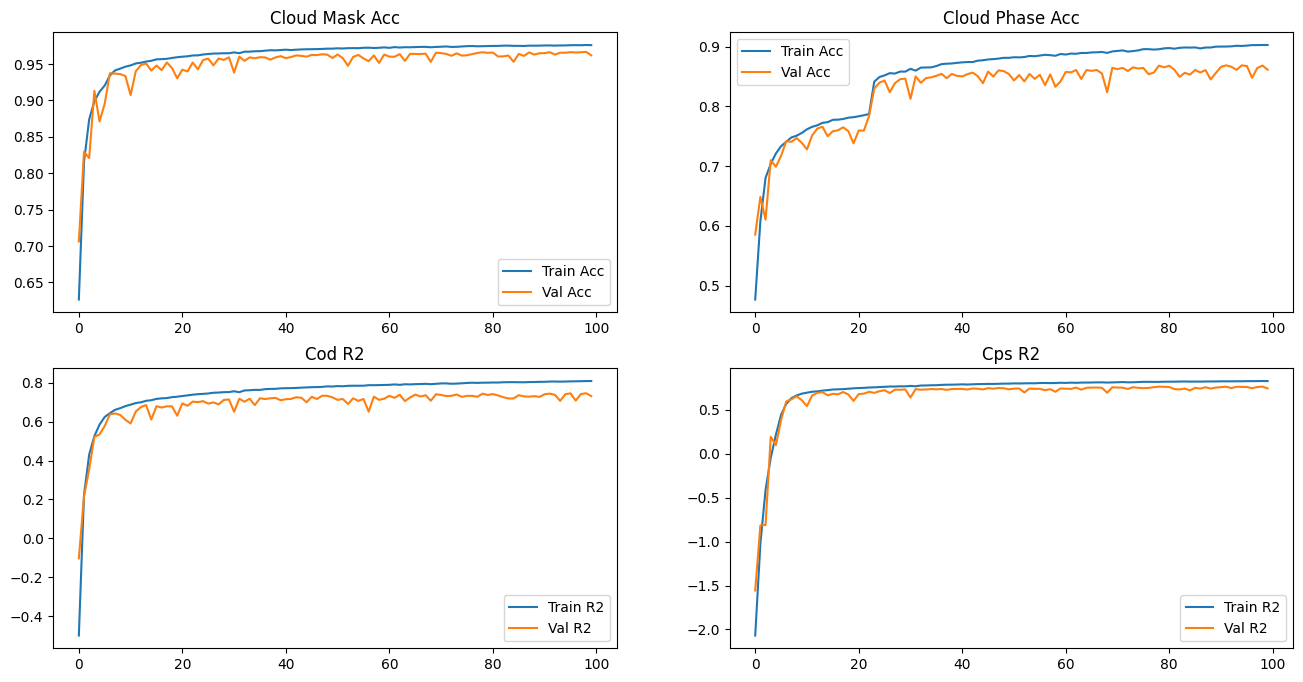

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.2_acc.png")  

plt.show()


In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  6.17it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.961     0.857     0.906   5803166
           1      0.957     0.989     0.973  18740066

    accuracy                          0.958  24543232
   macro avg      0.959     0.923     0.939  24543232
weighted avg      0.958     0.958     0.957  24543232

CONFUSION MATRIX:
 [[ 4971314   831852]
 [  202818 18537248]]

IOU: [0.82772681 0.94713497]
Unweighted IoU: 0.8874308927188336
Weighted IoU: 0.9189013078084557


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.918     0.849     0.882   4373397
           1      0.887     0.901     0.894  10864796
           2      0.737     0.790     0.762   2400565
           3      0.440     0.441     0.441    890044
           4      0.874     0.871     0.873   6014430

    accuracy                          0.857  24543232
   macro avg      0.771     0.770     0.770  24543232
weighted avg      0.858     0.857     0.857  24543232

CONFUSION MATRIX:
 [[3713674  582051   28784    1380   47508]
 [ 288366 9785319  377780   58132  355199]
 [   5415  149044 1896167  252050   97889]
 [    790   39307  201274  392425  256248]
 [  37924  478682   69354  187114 5241356]]

IOU: [0.78915411 0.80777744 0.6160873  0.28258036 0.77405759]
Unweighted IoU: 0.6539313592095781
Weighted IoU: 0.7584006479859086


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:02<00:00,  5.33it/s]


r2: 0.7343478202819824
MSE: 0.30583029985427856


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  6.17it/s]


r2: 0.7433289289474487
MSE: 0.6166164875030518


In [15]:
# my_image = images[0].cpu().numpy()
# my_image = np.transpose(my_image, (1, 2, 0))
# phase_pred = preds[0].cpu().numpy()
# phase_target = cloud_phase_target[0].cpu().numpy()



# from netCDF4 import Dataset
# import numpy as np


# with Dataset('./maps/image1.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', my_image.shape[0])
#     ds.createDimension('y', my_image.shape[1])
#     ds.createDimension('band', my_image.shape[2])

#     var = ds.createVariable('radiance', 'f4', ('x', 'y', 'band'))
#     var[:] = my_image

#     var.units = 'unknown'  # optional metadata

# with Dataset('./maps/image2.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', phase_pred.shape[0])
#     ds.createDimension('y', phase_pred.shape[1])

#     var = ds.createVariable('prediction', 'f4', ('x', 'y'))
#     var[:] = phase_pred

#     var.units = 'unknown'  # optional metadata


# with Dataset('./maps/image3.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', phase_target.shape[0])
#     ds.createDimension('y', phase_target.shape[1])

#     var = ds.createVariable('target', 'f4', ('x', 'y'))
#     var[:] = phase_target

#     var.units = 'unknown'  # optional metadata

